# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

**Импортируем необходимые библиотеки и функции:**

In [1]:
!pip install scikit-learn==1.1.3 -q
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install phik -q
import phik
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, cross_val_score)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

**Загрузим наши таблицы:**

In [3]:
geo1 = pd.read_csv('/datasets/geo_data_0.csv')
geo1.info() 
geo1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo2 = pd.read_csv('/datasets/geo_data_1.csv')
geo2.info() 
geo2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo3 = pd.read_csv('/datasets/geo_data_2.csv')
geo3.info() 
geo3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Данные импортироваллись корректно. Выполним предобработку:**

In [6]:
geo1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
geo2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
geo3.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Пропусков в данных не оказалось, проверим на дубликаты:**

In [9]:
geo1.duplicated().sum()

0

In [10]:
geo2.duplicated().sum()

0

In [11]:
geo3.duplicated().sum()

0

**Дубликатов тоже не оказалось. Перейдем к исследовательскому анализу. Напишем функцию, строющую гистограмму и график ящика с усами:**

In [12]:
def charts(df, column):

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=20)
    plt.title(f'Гистограмма для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами для {column}')
    plt.tight_layout()
    plt.show()

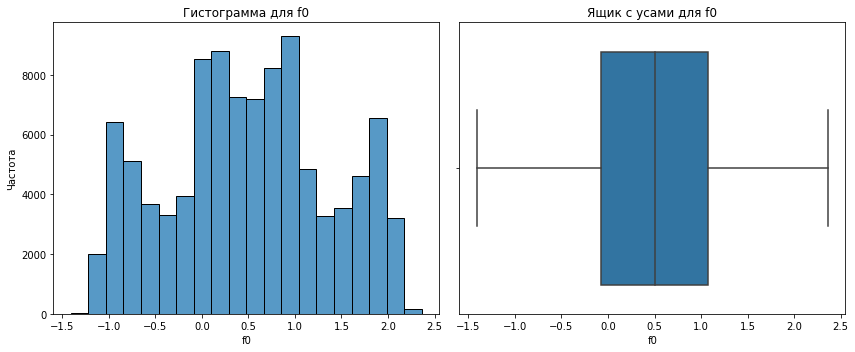

In [13]:
charts(geo1, 'f0')

**Видим распределение с 3 пиками и без выбросов. Значения варьируются от -1.5 до 2.5.**

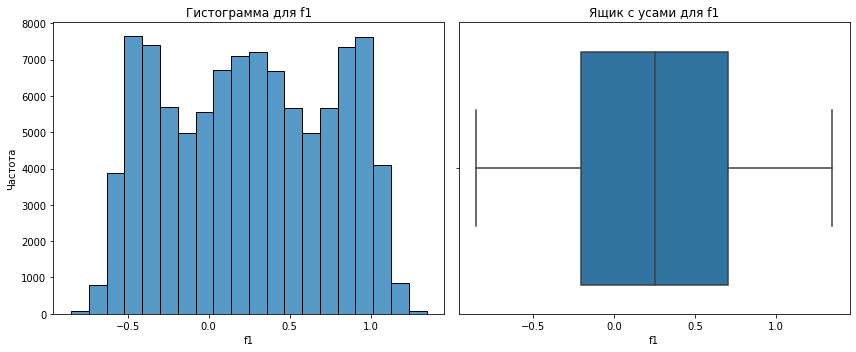

In [14]:
charts(geo1, 'f1')

**Тут также видим распределение с нескольками пиками и без выбросов. Значения варьируются от 0.1 до 1.2.**

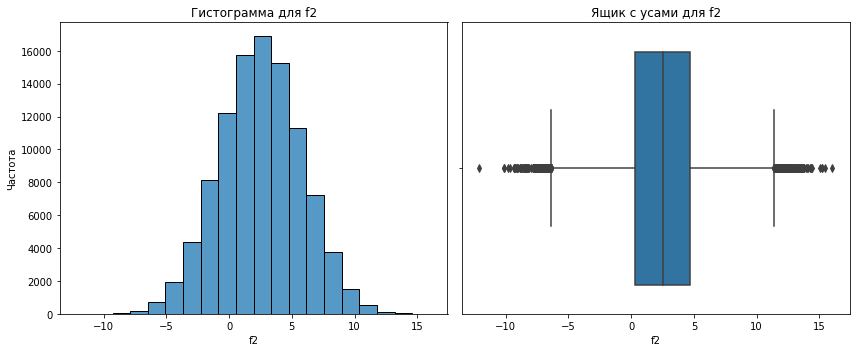

In [15]:
charts(geo1, 'f2')

**Видим нормальное распределение, но с большим числом выбросов. Так как в условиях нам не сказано что это за признаки(просто три признака точек), то сочтем их распределения адекватными, и ничего менять не будем.****

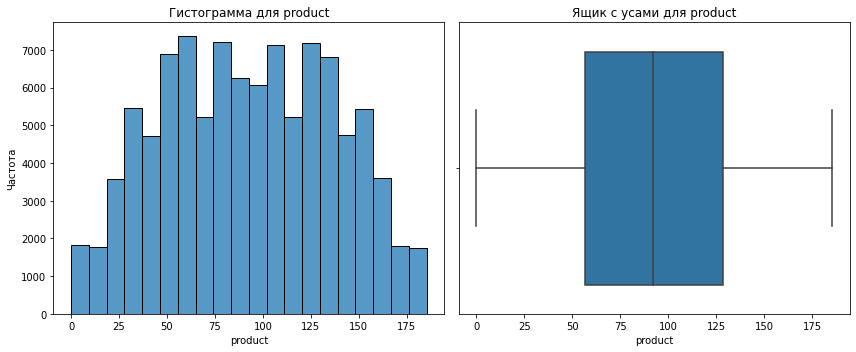

In [16]:
charts(geo1, 'product')

**Тут мы видим нормальное распределение с множеством пиков, но без выбросов. Переходим ко второй таблице:**

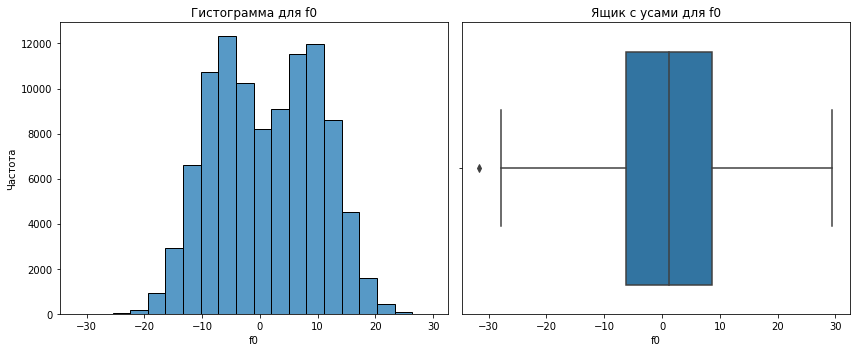

In [17]:
charts(geo2, 'f0')

**Видим аномалию в левой части графика, взглянем на эту строку:**

In [18]:
geo2[geo2['f0']<-30]

,id,f0,f1,f2,product
83601,jJm67,-31.609576,1.390042,4.001055,110.992147


**Выглядит довольно правдоподобно, скорее всего это не аномалия а выброс.**

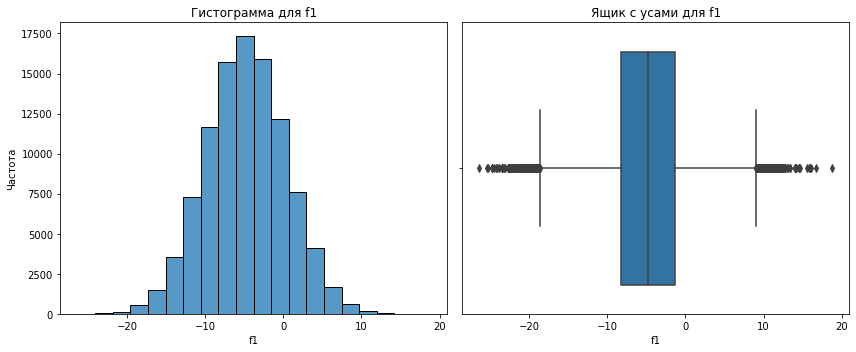

In [19]:
charts(geo2, 'f1')

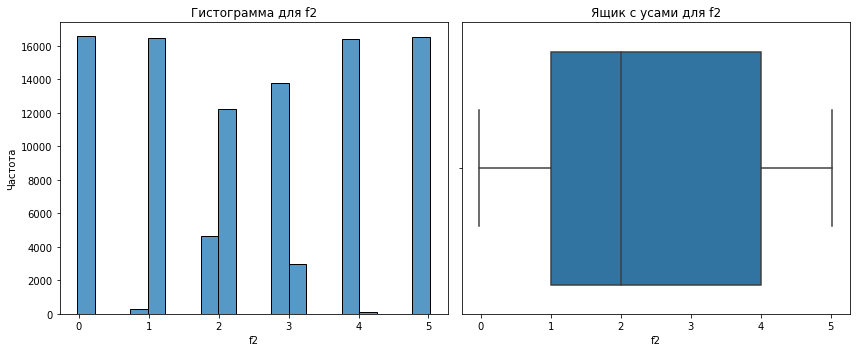

In [20]:
charts(geo2, 'f2')

**На этих двух графиках разные распределения, однако нет выброс. И т.к. нам ничего не сказано про эти признаки, будем считать что с ними все нормально.**

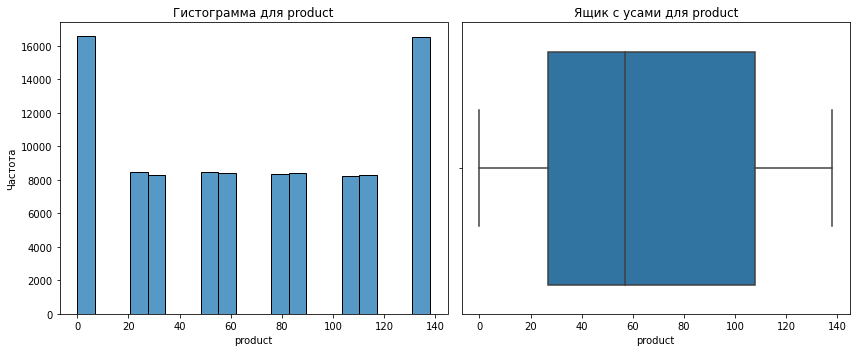

In [21]:
charts(geo2, 'product')

**Тут признак распределен в нескольких промежутках. Возможно это связано с прошлым признаком(месторождения находятся в нескольких скоплениях близко друг к другу, и имеюют схожие запасы нефти.**

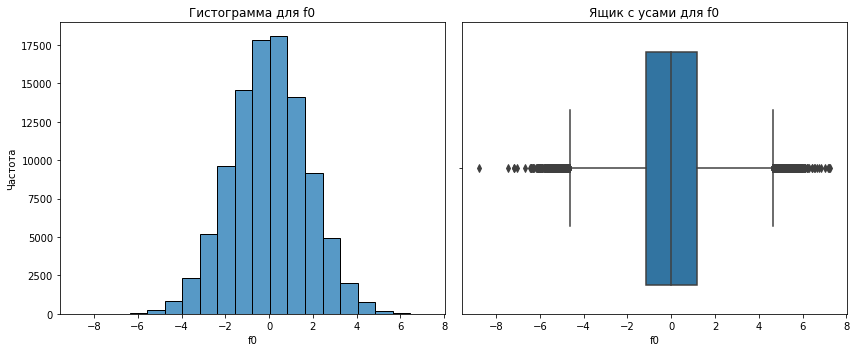

In [22]:
charts(geo3, 'f0')

**Видим аномалию слева на гарфике. Скорее всего это просто выброс, нужно в этом убедится, взглянем на эти строки:**

In [23]:
geo3[geo3['f0']<-8]

,id,f0,f1,f2,product
68126,onzVI,-8.760004,2.528391,6.552393,163.580588


**Наши догадка подтвердилась.**

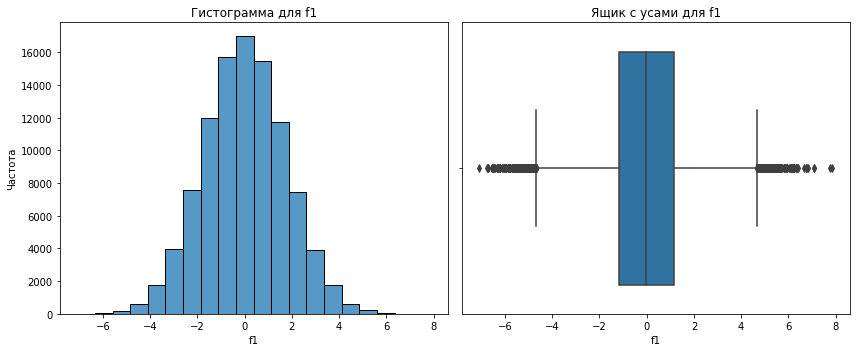

In [24]:
charts(geo3, 'f1')

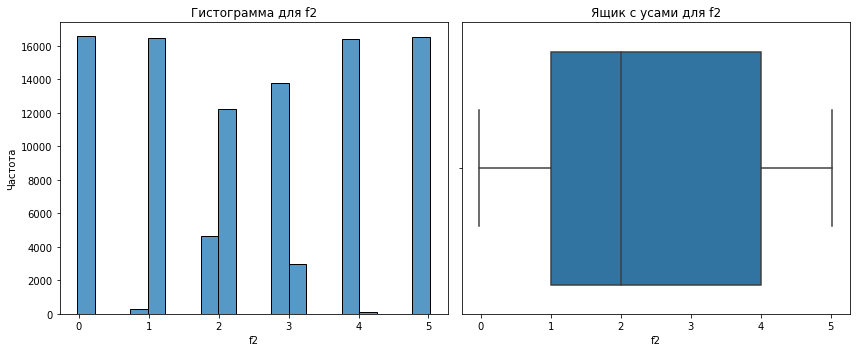

In [25]:
charts(geo2, 'f2')

**Тут схожая ситуация со второй таблицей, признак f1 распределен нормально, а f2 в определенных интервалах.**

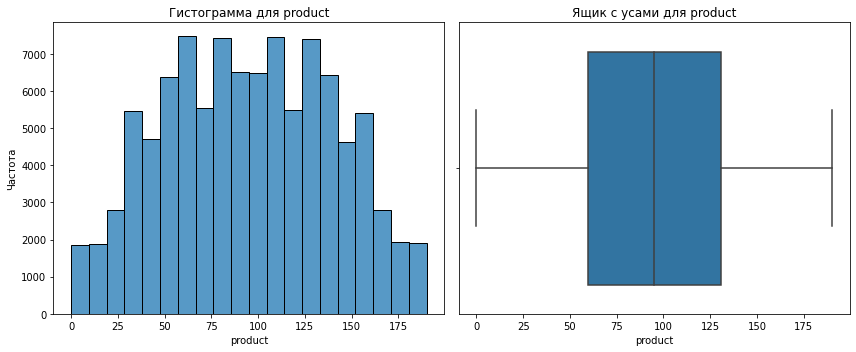

In [26]:
charts(geo3, 'product')

**Однаков продукт в третий таблице распределен нормально, с некоторыми пиками, но без выбросв и аномалий.**

**Мы проверили все признаки во всем таблицах на выбросы и аномалии, изучили их распределения. Теперь можно приступать к обучению модели.**

## Обучение и проверка модели

**Напишем функцию, в которой будем обучать модель, делать предсказания и считать необходимые метрики. На выходе она будет выводить метрики и возвращать таблицу, с предсказанным запасом сырья рядом с целевым.**

In [27]:
def model (df, ):
    RANDOM_STATE = 42
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE)
    X_valid = X_test.reset_index(drop=True)
    y_valid = y_test.reset_index(drop=True)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model  = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mean = pred.mean()
    pred = pd.DataFrame(pred, columns=['predict'])
    val = pd.concat([X_valid, y_valid, pred], axis=1)
    print(f'RMSE: {rmse}')
    print(f'Средний запас предсказанного сырья: {mean}')
    
    return val

**Применим функцию для первого региона**

In [28]:
val1 = model(geo1)
val1

RMSE: 37.75660035026169
Средний запас предсказанного сырья: 92.39879990657768


,f0,f1,f2,product,predict
0,0.599283,-0.557623,2.121187,122.073350,101.901017
1,0.739017,-0.463156,-1.347584,48.738540,78.217774
2,1.422743,-0.534917,3.718798,131.338088,115.266901
3,1.580244,-0.238458,2.805149,88.327757,105.618618
4,0.918974,0.023961,2.598575,36.959266,97.980185
...,...,...,...,...,...
24995,0.754647,-0.512213,2.610771,148.821520,105.076959
24996,-0.062056,0.516884,0.714446,123.454003,74.768176
24997,0.593769,-0.425260,-0.525017,91.945213,82.544397
24998,0.198209,0.453940,1.497557,149.295563,81.826689


**Применим функцию для второго региона**

In [29]:
val2 = model(geo2)
val2

RMSE: 0.8902801001028846
Средний запас предсказанного сырья: 68.7128780391376


,f0,f1,f2,product,predict
0,6.078076,0.084568,0.002957,0.000000,0.844738
1,16.462386,2.712946,1.993030,53.906522,52.921612
2,7.051898,0.766983,4.990194,134.766305,135.110385
3,-0.240045,-0.380804,3.999693,107.813044,109.494863
4,13.350111,-8.558281,0.002010,0.000000,-0.047292
...,...,...,...,...,...
24995,8.141417,-0.832158,4.001976,107.813044,108.351600
24996,16.601751,-8.141232,2.010371,53.906522,53.604049
24997,14.674777,-5.633890,1.004171,26.953261,26.708734
24998,-1.381118,-5.464254,4.001648,110.992147,109.823087


**Применим функция для третьего региона:**

In [30]:
val3 = model(geo3)
val3

RMSE: 40.145872311342174
Средний запас предсказанного сырья: 94.77102387765939


,f0,f1,f2,product,predict
0,2.111118,-1.679773,3.112240,117.441301,98.301916
1,0.734759,0.747788,3.670879,47.841249,101.592461
2,-2.513109,0.844631,-4.922889,45.883483,52.449099
3,-2.035301,-1.522988,5.072839,139.014608,109.922127
4,2.744145,1.429952,-1.372661,84.004276,72.411847
...,...,...,...,...,...
24995,-1.532677,0.365315,3.840436,40.797226,102.764169
24996,1.381244,1.168552,2.262261,87.144239,93.431823
24997,2.902487,0.839203,-2.817721,52.039812,64.098390
24998,0.942093,-1.424641,0.567559,136.961454,83.764135


**В результате мы получили 3 модели: метрика 1 и 3 модели оставляют желать лучшего, а вот вторая модель показала себя очень хорошо. Теперь можно приступить к подготовке к расчету прибыли.**

## Подготовка к расчёту прибыли

**Всего на разработку скважин выделено 10 млрд рублей. Компания хочет разработать 200 скважин, почситаем сколько выделяется на одну скважину:**

In [31]:
BUDGET = 10000000000
NUMBER_OF_WELLS = 200
BUDGET_ONE_WELL = BUDGET/NUMBER_OF_WELLS
BUDGET_ONE_WELL

50000000.0

**Бюджет разработки одной скважины составляет 50 млн. рублей. Доход с каждой единицы продукта составляет 450 тыс. рублей, найдем достаточный объём сырья для безубыточной разработки новой скважины:**  

In [32]:
ONE_THOUSANT_BARRELS_COST = 450000
REQUIRED_VOLUME = BUDGET_ONE_WELL/ONE_THOUSANT_BARRELS_COST
REQUIRED_VOLUME

111.11111111111111

**Необходимое количество сырья для безубыточной разработки составляет 111.2. Это больше, чем среденее предсказанное любой из таблиц. Скорее всего это озночает, что не все регионы можно будет рекомендовать к разработке.**

## Расчёт прибыли 

**Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**

In [33]:
def revenue(target, predictions, count):
    prediction_sorted = predictions.sort_values(ascending=False)
    selected = target.loc[prediction_sorted.index][:count]
    return (ONE_THOUSANT_BARRELS_COST * selected.sum()) - (count*BUDGET_ONE_WELL)

## Расчёт рисков

**Напишем функцию, которая считает риски и прибыль для каждого региона с помощью техники Boostrap с 1000 выборок:**

In [34]:
def risk(df):
    state = np.random.RandomState(12345)  
    values = []
    for i in range(1000):
        target_subsample = df['product'].sample(n=500, replace=True, random_state=state)
        predictions_subsample = df['predict'].loc[target_subsample.index]
        values.append(revenue(target_subsample, predictions_subsample, 200))
    values = pd.Series(values)
    lower = values.quantile(0.025)
    high = values.quantile(0.975)
    mean = values.mean()
    risk_of_loss = np.mean(np.array(values) <0)
    print("Средняя прибыль региона:", mean)
    print("Доверительный интервал для прибыли:", lower, ':', high)
    print(f"Риск убытков для региона: {risk_of_loss:.2%}")

In [35]:
risk(val1)

Средняя прибыль региона: 435933772.1386621
Доверительный интервал для прибыли: -116231612.77720818 - 966504180.707376
Риск убытков для региона: 6.10%


**Теперь сделаем все тоже самое для второго региона:**

In [36]:
risk(val2)

Средняя прибыль региона: 489661254.41175246
Доверительный интервал для прибыли: 55116177.27361494 - 905762650.4248402
Риск убытков для региона: 1.10%


**И для  третьего региона:**

In [37]:
risk(val3)

Средняя прибыль региона: 403687927.86213845
Доверительный интервал для прибыли: -153116984.7619049 - 952887416.7078604
Риск убытков для региона: 7.10%


**Исходя из условия выбора скважины о том, что вероятность убытков должна быть меньше 2.5%, делаем вывод что нам подходит только второй регион, в нем как раз наибольшая средняя выручка.**

## Вывод

**В ходе работ по этому проекту, нами был проделан полный путь анализа трех регионов для разработки скважин. Мы загрузили и предобработали данные, исследовали их, а затем для каждого из регионов построили модели, предсказывающие объем сырья в скважинах. После этого с помощью техники Bootstrap мы нашли среднюю выручку и риск убытков для каждого из регионов. На основе этих данных мы выбрали подходящий нам регион - второй регион. Он подходит из-за низкого риска убытков и из-за самой выскокой средней вырчки**